### Build a image x label adjacency matrix (oh i miss babai)

In [1]:
import os
import numpy as np
import re
import csv
import glob
from matplotlib import pyplot as plt
from PIL import Image
from scipy.misc import imresize

In [2]:
DATA_DIRECTORY = "../../../project/rcc/deep_learning_hack/netdissect/broden1_224/"
OUTPUT_FOLDER = "../../../project2/bermanm/netdissect/"
FEATURE_NAMES = ["layer4"]

categories_pixels = ['color', 'object', 'part', 'material']
categories_scalars = ['scene', 'texture']

In [3]:
def decode_index_dict(row):
    result = {}
    for key, val in row.items():
        if key in ['image', 'split']:
            result[key] = val
        elif key in ['sw', 'sh', 'iw', 'ih']:
            result[key] = int(val)
        else:
            item = [s for s in val.split(';') if s]
            for i, v in enumerate(item):
                if re.match('^\d+$', v):
                    item[i] = int(v)
            result[key] = item
    return result

In [4]:
def decode_label_dict(row):
    result = {}
    for key, val in row.items():
        if key == 'category':
            result[key] = dict((c, int(n))
                for c, n in [re.match('^([^(]*)\(([^)]*)\)$', f).groups()
                    for f in val.split(';')])
        elif key == 'name':
            result[key] = val
        elif key == 'syns':
            result[key] = val.split(';')
        elif re.match('^\d+$', val):
            result[key] = int(val)
        elif re.match('^\d+\.\d*$', val):
            result[key] = float(val)
        else:
            result[key] = val
    return result

In [5]:
with open(os.path.join(DATA_DIRECTORY, "index.csv")) as f:
    images = [decode_index_dict(r) for r in csv.DictReader(f)]

In [6]:
with open(os.path.join(DATA_DIRECTORY, "label.csv")) as f:
    labels = [decode_label_dict(r) for r in csv.DictReader(f)]

In [7]:
def build_image_vs_label(images, labels, save_path="matrix.npy"):
    if not os.path.exists(os.path.join(OUTPUT_FOLDER, "visualization")):
        os.makedirs(os.path.join(OUTPUT_FOLDER, 'visualization'))
    save_path = os.path.join(OUTPUT_FOLDER, "visualization", save_path)
    if os.path.exists(save_path):
        print("loading")
        return np.load(save_path)
    
    image_vs_label = np.zeros((len(images), len(labels)+1))
    for i, image in enumerate(images):
        if (i % 100 == 0):
            print(i)
        lbs = np.array([])
        for cat in categories_pixels:
            for lb_img in image[cat]:
                lb_img = Image.open(os.path.join(DATA_DIRECTORY, "images", lb_img))
                cat_lbs = np.unique(np.array(list(lb_img.getdata())))[1:]
                lbs = np.concatenate((lbs, cat_lbs))
        for cat in categories_scalars:
            lbs = np.concatenate((lbs, np.array(image[cat])))
        lbs = np.unique(lbs.astype(int))
        image_vs_label[i].put(lbs, [1])
    np.save(save_path, image_vs_label)
    return image_vs_label

In [8]:
ivl = build_image_vs_label(images, labels)

loading


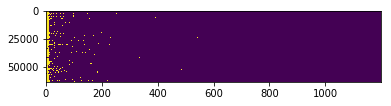

In [9]:
plt.imshow(ivl, aspect=0.004)

### single probe

In [10]:
cp = {0: (230, 255, 255),
        1: (0, 0, 0),
          2: (128, 128, 128),
          3: (255, 255, 255),
          4: (153, 102, 51),
          5: (0, 153, 51),
          6: (255, 153, 204),
          7: (153, 0, 255),
          8: (0, 0, 204),
          9: (255, 204, 0),
          10: (204, 0, 0),
          11: (255, 153, 0)}

In [11]:
size = 112
gap = 3
img_row = 432
img_col = 288

In [12]:
def pixel_concepts(image_id, img, concept, palette, labels=labels, dpi=1000):
    concept_labels = img[concept]
    for lbi, lb in enumerate(concept_labels):
        c_img = Image.open(os.path.join(DATA_DIRECTORY, "images", lb))
        unique_label = list(c_img.getdata())
        unique_label = np.unique(np.array([c[0] for c in unique_label]))
        unique_label = np.array([c for c in unique_label if c != 0])
        if list(unique_label) != []:
            label_map = {}
            label_map[0] = 0
            for i, label in enumerate(unique_label):
                label_map[label] = i+1

            c_pixel = c_img.load()
            gdheight = 1
            gdwidth = len(unique_label) + 1
            if concept == 'color':
                tiled = np.full(((size + gap) * gdheight - gap, (size + gap) * gdwidth - gap, 3), 255, dtype='uint8')
            else:
                tiled = np.full(((size + gap) * gdheight - gap, (size + gap) * gdwidth - gap, 4), 0, dtype='float')

            row = 0
            for col in range(len(unique_label) + 1):
                if col == len(unique_label):
                     c_img = np.array([[palette[label_map[c_pixel[i, j][0]]] for i in range(size)]
                         for j in range(size)])
                else:
                    c = unique_label[col]
                    c_img = np.array([[palette[label_map[c]] if c_pixel[i, j][0] == c else palette[0]
                               for i in range(size)] for j in range(size)])
                tiled[row * (size + gap) : row * (size + gap) + size, 
                        col * (size + gap) : col * (size + gap) + size,:] = c_img

            locs = np.arange(size // 2, gdwidth * size, size + gap)
            curr_labels = [labels[c-1]['name'] for c in unique_label] + ['combined']
            filename = str(image_id) + "_" + concept + "_" + str(lbi + 1) + ".png"
            plt.xticks(locs, curr_labels, rotation=90)
            plt.title(concept + " " + str(lbi + 1))
            plt.imshow(tiled)
            plt.savefig(os.path.join(OUTPUT_FOLDER, "visualization", filename), dpi=dpi)
            plt.close()

In [13]:
def scalar_concepts(img, concept, labels=labels):
    res = ""
    if img[concept] != []:
        res = concept + ": "
        lbs = [labels[c-1]["name"] for c in img[concept]]
        res += ";".join(lbs)
    return res

In [14]:
def build_image(image_id, image_name, title):
    image = Image.open(os.path.join(DATA_DIRECTORY, "images", image_name))
    plt.imshow(image)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(OUTPUT_FOLDER, "visualization", str(image_id) + ".png"), dpi=1000)

In [15]:
def probe(image_id, mode=None, images=images, labels=labels, color_palette=cp, max_labels=60, dpi=1000):
    hsv = plt.get_cmap('hsv')
    dp = hsv(np.linspace(0, 1.0, 60))
    dp = np.random.permutation(dp)
    dp_map = {}
    for i in range(max_labels):
        if i == 0:
            dp_map[i] = [0., 0.8, 1., 0.05]
        else:
            dp_map[i] = dp[i]

    img = images[image_id]
    img_name = img['image']
    dataset = img_name.split("/")[0]
    filename = img_name.split("/")[1]
    
    title = dataset + "_" + filename
    build_image(image_id, img_name, title)
    print("Dataset: {}".format(dataset))
    print("Image Name: {}".format(filename))

    pixel_concepts(image_id, img, "color", color_palette, dpi=dpi)
    pixel_concepts(image_id, img, "object", dp_map, dpi=dpi)
    pixel_concepts(image_id, img, "part", dp_map, dpi=dpi)
    pixel_concepts(image_id, img, "material", dp_map, dpi=dpi)
    
    if mode != None:
        file = os.path.join(OUTPUT_FOLDER, "visualization", str(image_id) + "_" + mode[:-1] + "_" + mode[-1] + ".png")
        f_img = Image.open(file)
        plt.imshow(f_img)
        plt.xticks([])
        plt.yticks([])
    else:
        files = sorted(glob.glob(os.path.join(OUTPUT_FOLDER, "visualization", str(image_id) + "*.png")))
        length = len(files)

        result = Image.new("RGB", (img_row, img_col * (length)))
        for i, file in enumerate(files):
            r_img = Image.open(file)
            r_img.thumbnail((img_row, img_col), Image.ANTIALIAS)
            x = i // (length) * img_row
            y = i % (length) * img_col
            w, h = r_img.size
            result.paste(r_img, (x, y, x + w, y + h))

        plt.imshow(result)
        plt.xticks([])
        plt.yticks([])
        #plt.suptitle(title, size="large")
        scene = scalar_concepts(img, "scene")
        texture = scalar_concepts(img, "texture")
        subtitle = "[" + str(image_id) + "] " + scene + " " + texture
        plt.title(subtitle, size="large")
        filename = os.path.join(OUTPUT_FOLDER, "visualization", str(image_id) + "_combined.jpg")
        plt.savefig(filename, dpi=dpi)

Dataset: ade20k
Image Name: ADE_train_00018276.jpg


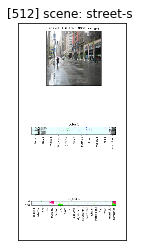

In [183]:
p = probe(512, dpi=500)

In [181]:
filename = os.path.join(OUTPUT_FOLDER, "visualization", str(512) + "_combined.jpg")
view = Image.open(filename)

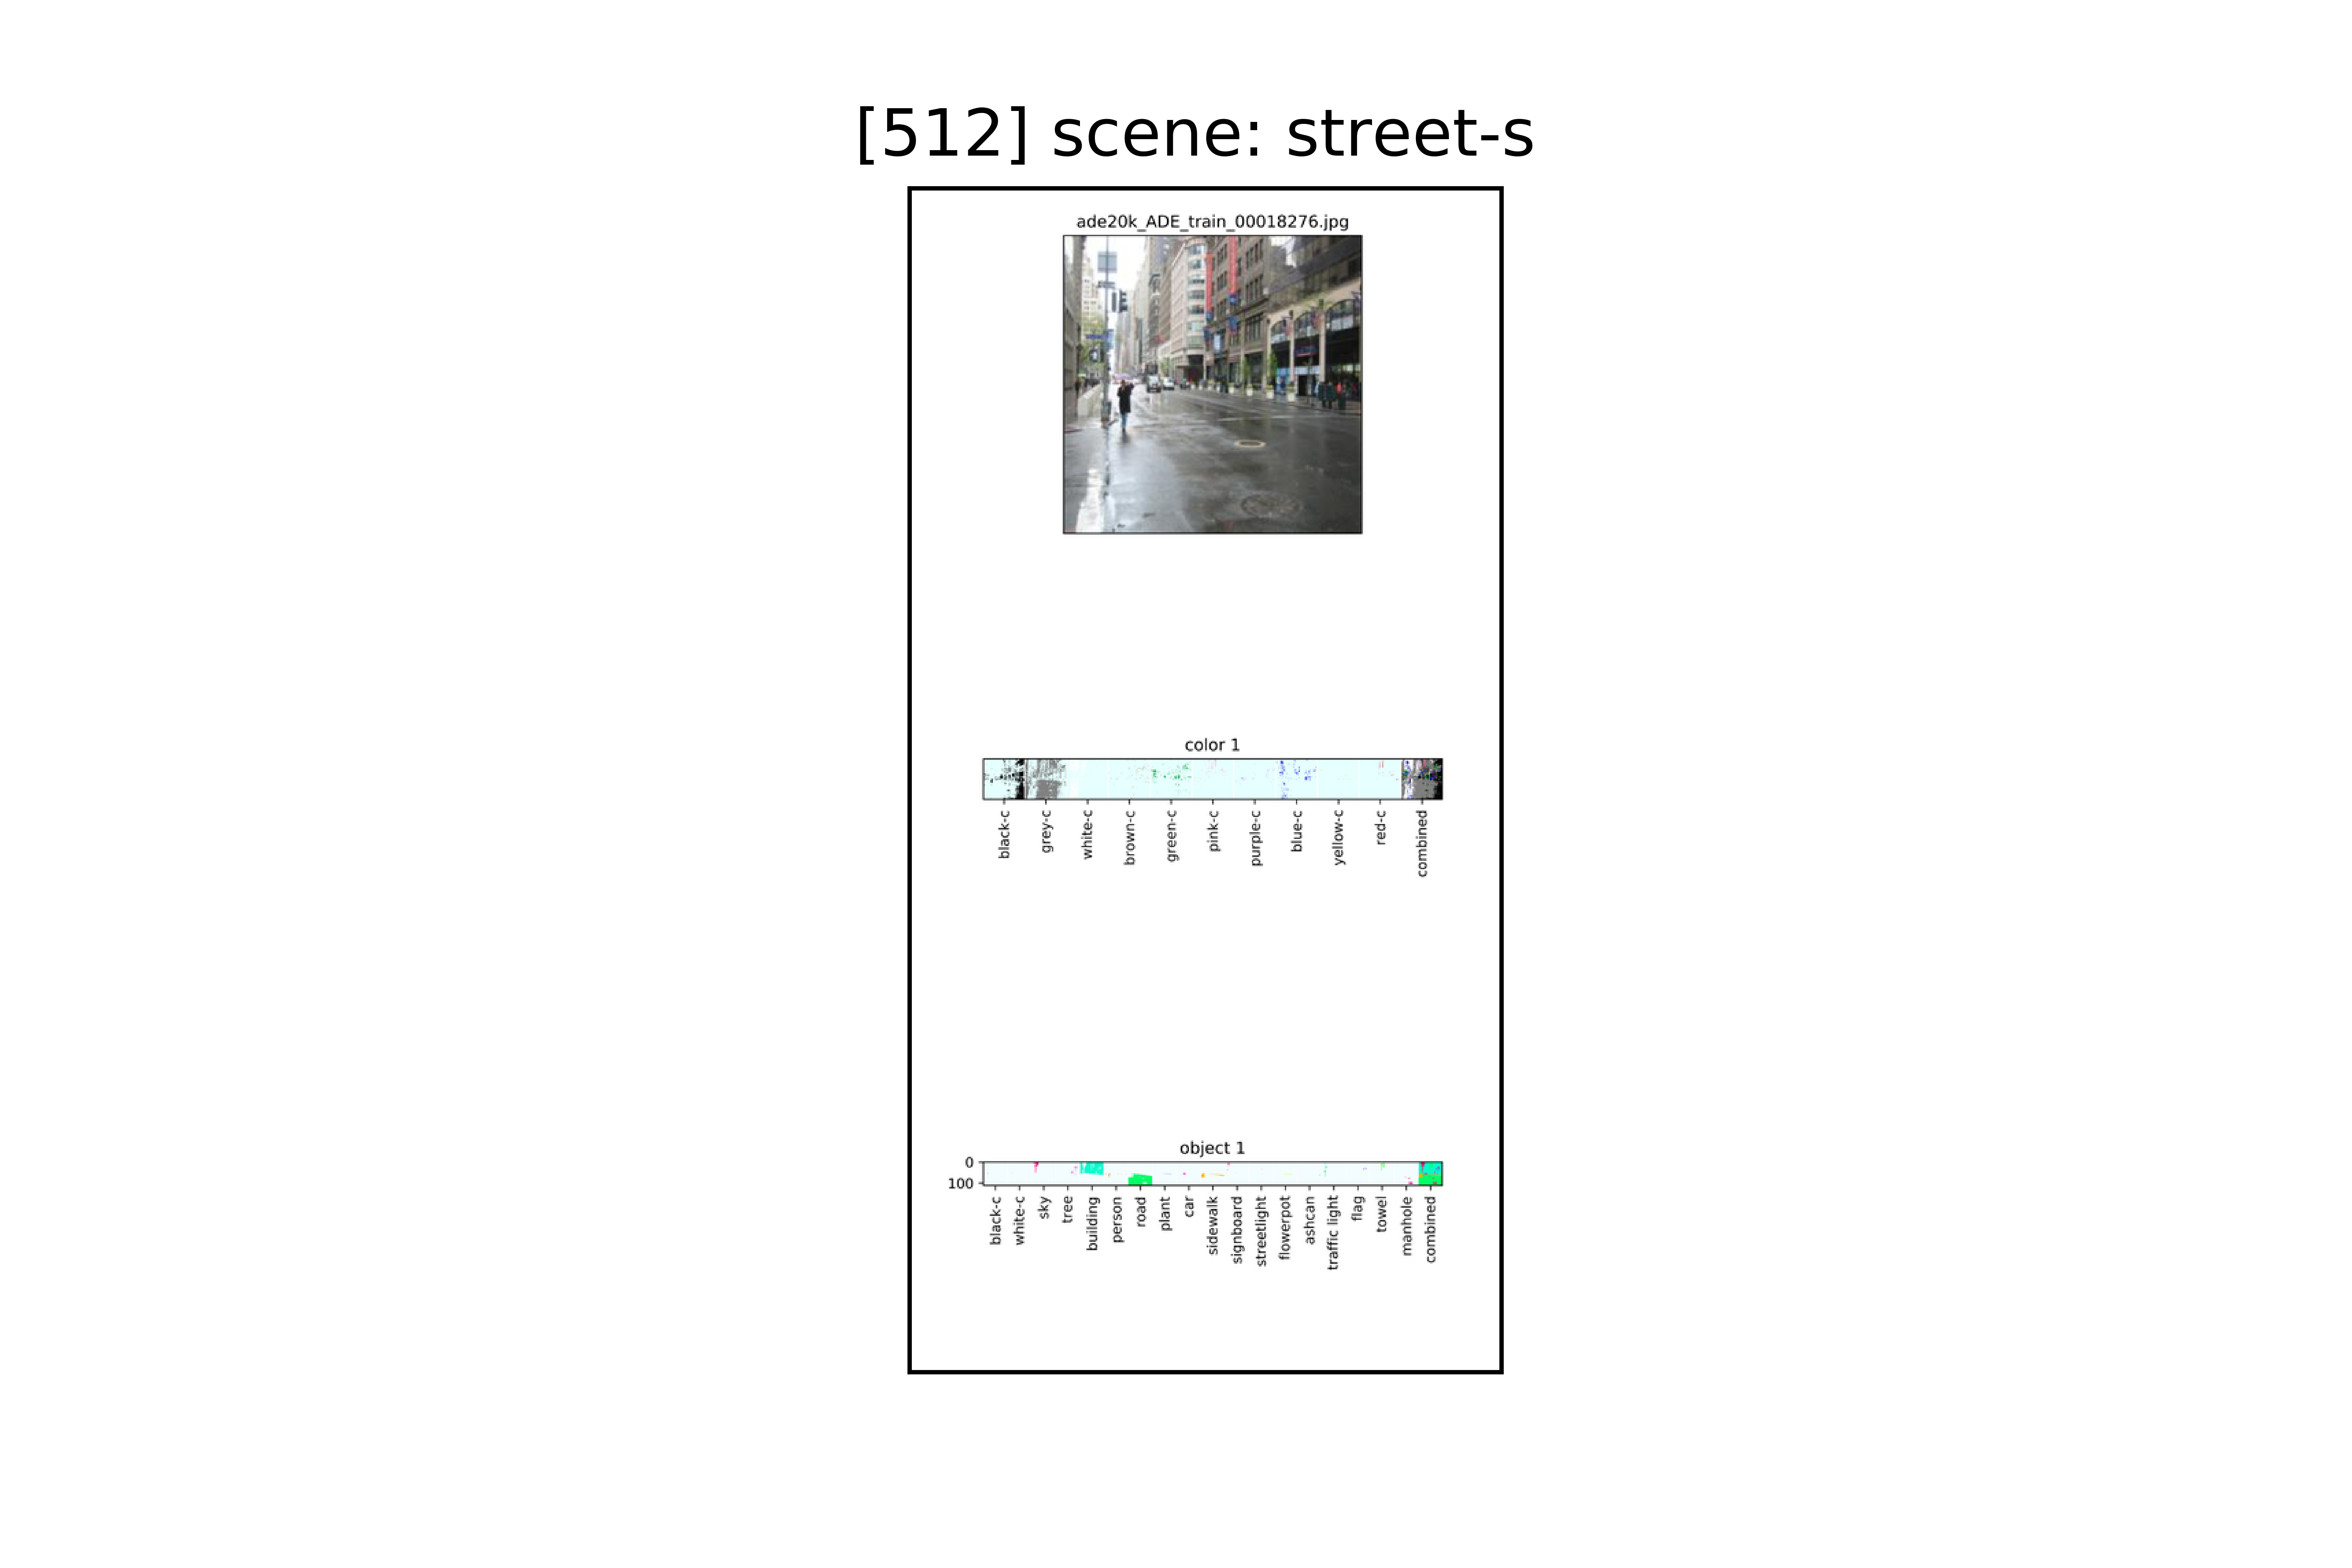

In [182]:
view

### visualize feature map

In [19]:
def load_feature_map():
    feature_path = os.path.join(OUTPUT_FOLDER, "dissection", "resnet18_places365")
    qtpath = os.path.join(OUTPUT_FOLDER, "dissection", "resnet18_places365", "quantile.npy")
    
    maxfeatures = [None] * len(FEATURE_NAMES)
    wholefeatures = [None] * len(FEATURE_NAMES)
    features_size = np.load(os.path.join(feature_path, "feature_size.npy"))
    mmap_files =  [os.path.join(feature_path, "%s.mmap" % feature_name)  for feature_name in FEATURE_NAMES]
    mmap_max_files = [os.path.join(feature_path, "%s_max.mmap" % feature_name) for feature_name in FEATURE_NAMES]
    for i, (mmap_file, mmap_max_file) in enumerate(zip(mmap_files,mmap_max_files)):
        wholefeatures[i] = np.memmap(mmap_file, dtype=float,mode='r', shape=tuple(features_size[i]))
        maxfeatures[i] = np.memmap(mmap_max_file, dtype=float, mode='r', shape=tuple(features_size[i][:2]))
        
    thresholds = np.load(qtpath)
    return wholefeatures[0], maxfeatures[0], thresholds

In [20]:
wholefeature, maxfeature, thresholds = load_feature_map()

In [21]:
def probe_unit_fm(image_id, resize=112, images=images, wf=wholefeature, mf=maxfeature, unit_id=None): # data is not shuffled! hurray!!!
    wholef = wf[image_id]
    maxf = mf[image_id]
    if unit_id == None:
        print("No unit id provided, will probe the unit id with maximum activation")
        unit_id = np.argmax(maxf)
    feature_map = wholef[unit_id]
    feature_map = imresize(feature_map, (resize, resize), mode='F')
    plt.imshow(feature_map, "hot")
    return unit_id, feature_map

No unit id provided, will probe the unit id with maximum activation


/home/canliu/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(172, array([[3.0014696 , 3.0014696 , 3.0014696 , ..., 1.4446577 , 1.4446577 ,
         1.4446577 ],
        [3.0014696 , 3.0014696 , 3.0014696 , ..., 1.4446577 , 1.4446577 ,
         1.4446577 ],
        [3.0014696 , 3.0014696 , 3.0014696 , ..., 1.4446577 , 1.4446577 ,
         1.4446577 ],
        ...,
        [1.3475941 , 1.3475941 , 1.3475941 , ..., 0.88687867, 0.88687867,
         0.88687867],
        [1.3475941 , 1.3475941 , 1.3475941 , ..., 0.88687867, 0.88687867,
         0.88687867],
        [1.3475941 , 1.3475941 , 1.3475941 , ..., 0.88687867, 0.88687867,
         0.88687867]], dtype=float32))

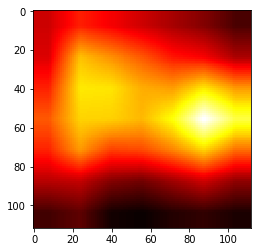

In [22]:
probe_unit_fm(1, unit_id=None)

In [23]:
def show_activated(image_id, images=images, th=thresholds, wf=wholefeature, mf=maxfeature, unit_id=None):
    unit_id, feature_map = probe_unit_fm(image_id, images=images, resize=224, wf=wf, mf=mf, unit_id=unit_id)
    
    print("Threshold for unit {}: {}".format(unit_id, th[unit_id]))
    print("Maximum activation for unit {}: {}".format(unit_id, np.max(wf[image_id][unit_id])))
    
    image = Image.open(os.path.join(DATA_DIRECTORY, "images", images[image_id]["image"])).convert("RGBA")
    feature_map[feature_map < th[unit_id]] = 0
    feature_map = feature_map / mf[image_id][unit_id]
    feature_map = Image.fromarray(np.uint8(plt.cm.hot(feature_map)*255)) # there might be some issues here
    combined = Image.blend(image, feature_map, 0.7)
    plt.imshow(combined)

/home/canliu/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Threshold for unit 172: 4.474766307200177
Maximum activation for unit 172: 8.770739555358887


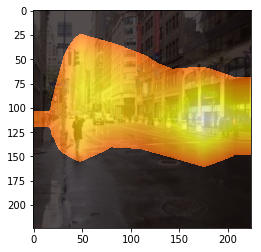

In [192]:
show_activated(512, unit_id=172)

### visualize IOU

In [25]:
def fetch_labels(img, labels=labels):
    label_ids = np.array([])
    for cat in categories_pixels:
        for cat_img in img[cat]:
            cat_lbs = np.unique(np.array(list((Image.open(os.path.join(DATA_DIRECTORY, "images", cat_img)).getdata()))))[1:]
            label_ids = np.concatenate((label_ids, cat_lbs))
    for cat in categories_scalars:
        label_ids = np.concatenate((label_ids, np.array(img[cat])))
    return np.uint16(np.unique(label_ids))

In [186]:
def label_unit_IOU(image_id, th=thresholds, wf=wholefeature, mf=maxfeature, images=images, labels=labels):
    image_labels = fetch_labels(images[image_id], labels=labels)
    activated_units = np.argwhere(mf[image_id] > thresholds).flatten()
    
    num_units = len(activated_units)
    num_labels = len(image_labels)
    
    print("{} related labels, {} activated units".format(num_labels, num_units))
    tally_units = np.zeros(num_units,dtype=np.float64) # units
    tally_temp_labels = np.zeros(np.max(image_labels)+1, dtype=np.float64)
    tally_temp_both = np.zeros((np.max(image_labels)+1, num_units), dtype=np.float64)
    
    img = images[image_id]
    scalars, pixels = [], []
    for cat in categories_pixels:
        cat_pixels = []
        for cat_img in img[cat]:
            cat_img = Image.open(os.path.join(DATA_DIRECTORY, "images", cat_img))
            cat_lbs = list(cat_img.getdata())
            cat_lbs = np.array([t[0] for t in cat_lbs]).reshape(size, size)
            cat_pixels.append(cat_lbs)
        if cat_pixels:
            cat_pixels = np.concatenate(cat_pixels)
            pixels.append(np.array([cat_pixels]))
    pixels = np.concatenate(pixels)
    pixels_label = np.bincount(pixels.ravel())

    for cat in categories_scalars:
        scalars += img[cat]
        
    tally_temp_labels[:len(pixels_label)] += pixels_label
    tally_temp_labels[scalars] += size * size
    
    tally_labels = tally_temp_labels[tally_temp_labels != 0] # labels
    if len(tally_labels) > num_labels:
        tally_labels = tally_labels[1:] # exclude 0 
    
    for ind, unit_id in enumerate(activated_units):
        _, feature_map = probe_unit_fm(image_id, images=images, wf=wf, mf=mf, unit_id=unit_id)
        indexes = np.argwhere(feature_map > th[unit_id])
        tally_units[ind] += len(indexes)
        
        if len(pixels) > 0:
            tally_bt = np.bincount(pixels[:, indexes[:, 0], indexes[:, 1]].ravel())
            tally_temp_both[:len(tally_bt), ind] += tally_bt
        
        for scalar in scalars:
            tally_temp_both[scalar, ind] += len(indexes)
    
    tally_both = tally_temp_both[np.array([image_labels]), :][0] # intersection
    tally_units = np.tile(tally_units, (num_labels, 1))
    tally_labels = np.tile(tally_labels[:, np.newaxis], (1, num_units))

    iou_matrix = tally_both / (tally_units + tally_labels - tally_both + 1e-10)
    label_names = [labels[i-1]['name'] for i in image_labels]
    ylocs = np.arange(num_labels)
    xlocs = np.arange(num_units)
    plt.yticks(ylocs, label_names, size=5)
    plt.xticks(xlocs, activated_units, rotation=90, size=4)
    plt.imshow(iou_matrix, "hot")
    plt.savefig(os.path.join(OUTPUT_FOLDER, "visualization", str(image_id)+"_iou.png"), dpi=500) 

27 related labels, 28 activated units


/home/canliu/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


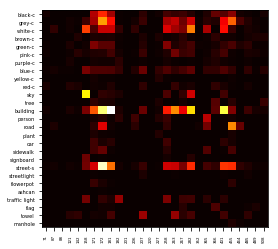

In [187]:
label_unit_IOU(512)

In [189]:
image_id = 512
vis = Image.open(os.path.join(OUTPUT_FOLDER, "visualization", str(image_id)+"_iou.png"))

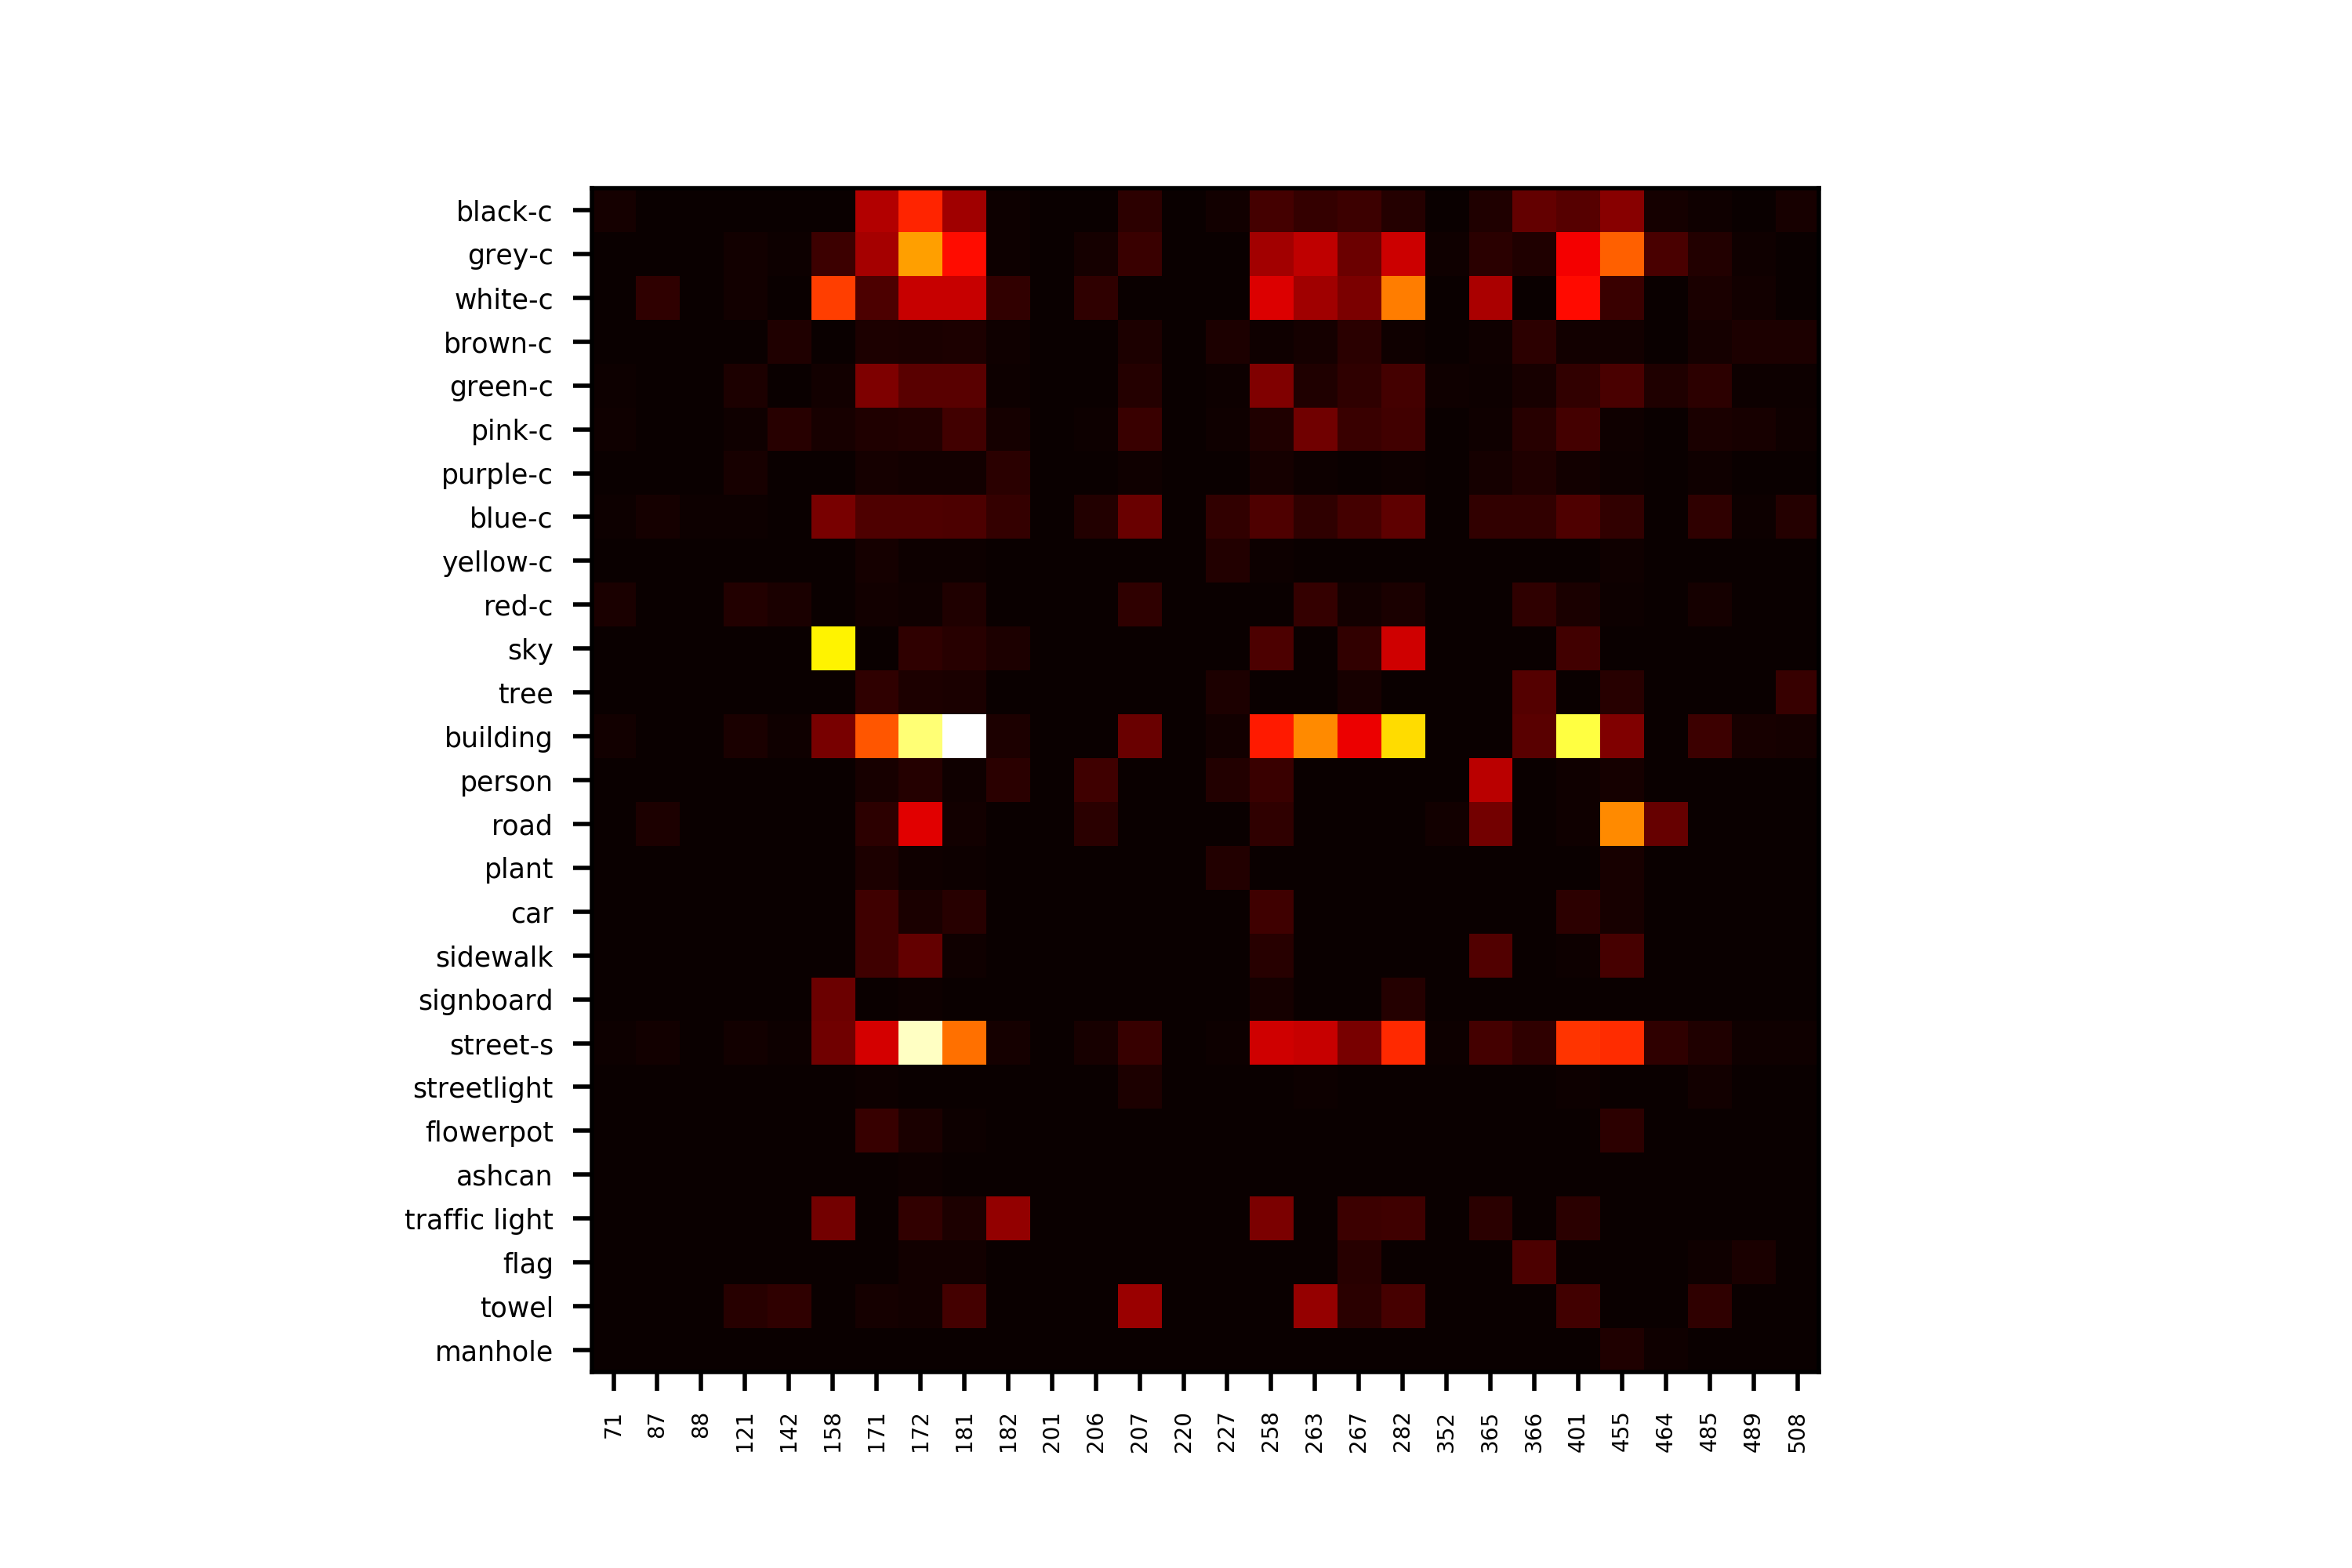

In [190]:
vis